<a href="https://colab.research.google.com/github/SSSpock/American-Gut/blob/master/caption_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Objective is to test various image captioning tools

In [ ]:
!pip install transformers
!pip install transformers datasets
!pip install torch

In [ ]:
from PIL import Image
from transformers import pipeline

In [ ]:
classifier = pipeline("vqa")

No model was supplied, defaulted to dandelin/vilt-b32-finetuned-vqa and revision 4355f59 (https://huggingface.co/dandelin/vilt-b32-finetuned-vqa).
Using a pipeline without specifying a model name and revision in production is not recommended.


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


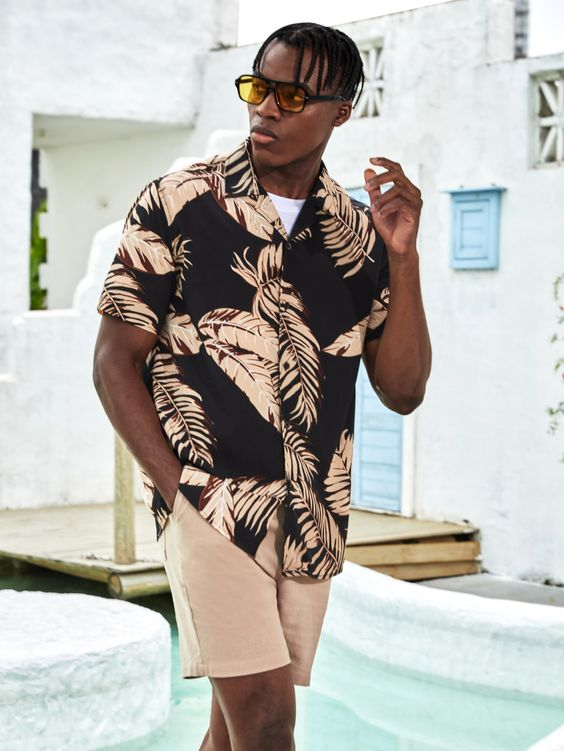

In [ ]:
# Define the file path
image_path = "/content/fashion_image_2.jpeg"  # Replace with your actual file path

# Open the image
image = Image.open(image_path)

# Display the image (optional)
image


In [ ]:
example = "/content/fashion_image_1.jpeg"
image = Image.open(example)
question = 'is the style sporty, trendy, formal, or casual'
print(question)
classifier(image, question, top_k=1)

is the style sporty, trendy, formal, or casual


[{'score': 0.48330461978912354, 'answer': 'formal'}]

## Clip Seg

In [ ]:
from transformers import AutoProcessor, CLIPSegForImageSegmentation
from PIL import Image
import requests
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import json
from PIL import Image
from PIL import ImageDraw
from typing import Union, Dict, List, Tuple
import io
import requests
import numpy as np
import logging
from collections import defaultdict

processor = AutoProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

preprocessor_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/974 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/603M [00:00<?, ?B/s]

In [ ]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
prompts = ["a cat", "a remote", "a blanket"]
inputs = processor(text=prompts, images=[image] * len(prompts), padding=True, return_tensors="pt")

outputs = model(**inputs)

logits = outputs.logits
print(logits.shape)

torch.Size([3, 352, 352])


In [ ]:
with torch.no_grad():
  outputs = model(**inputs)
preds = outputs.logits.unsqueeze(1)

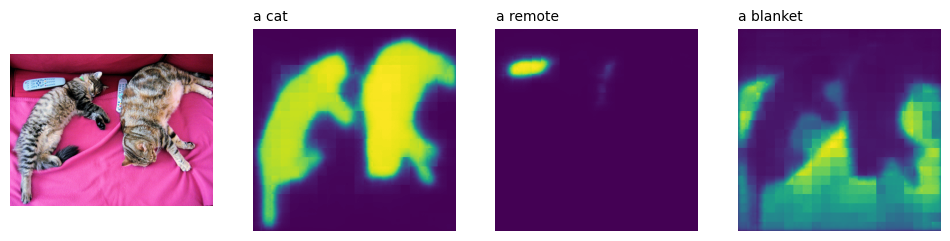

In [ ]:
_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];

## Fashion example

In [ ]:
clothing_categories = [
    "Men's Shirts (T-shirts, Dress Shirts, Tank Tops)",
    "Women's Tops (Blouses, T-shirts, Tank Tops)",
    "Dresses",
    "Skirts",
    "Men's Outerwear (Jackets, Coats, Hoodies)",
    "Women's Outerwear (Jackets, Coats, Hoodies)",
    "Men's Pants (Jeans, Trousers, Shorts)",
    "Women's Pants (Jeans, Trousers, Leggings)",
    "Shoes, Boots, Sandals",
    "Hats, Caps, Headscarves",
    "Sunglasses, Glasses",
    "Necklaces, Bracelets, Rings",
    "Handbags, Backpacks, Clutches",
    "Pajamas, Nightgowns, Lingerie",
    "Sportswear, Swimwear, Activewear",
    "Objects, Furniture, Non-Apparel Items"
]



In [ ]:
# Creating a mapping from categories to integers
category_to_int_map = {category: i for i, category in enumerate(clothing_categories)}

category_to_int_map

{"Men's Shirts (T-shirts, Dress Shirts, Tank Tops)": 0,
 "Women's Tops (Blouses, T-shirts, Tank Tops)": 1,
 'Dresses': 2,
 'Skirts': 3,
 "Men's Outerwear (Jackets, Coats, Hoodies)": 4,
 "Women's Outerwear (Jackets, Coats, Hoodies)": 5,
 "Men's Pants (Jeans, Trousers, Shorts)": 6,
 "Women's Pants (Jeans, Trousers, Leggings)": 7,
 'Shoes, Boots, Sandals': 8,
 'Hats, Caps, Headscarves': 9,
 'Sunglasses, Glasses': 10,
 'Necklaces, Bracelets, Rings': 11,
 'Handbags, Backpacks, Clutches': 12,
 'Pajamas, Nightgowns, Lingerie': 13,
 'Sportswear, Swimwear, Activewear': 14,
 'Objects, Furniture, Non-Apparel Items': 15}

In [ ]:
def segmentation_to_masks(segmentation_map: np.ndarray, label_list: List[str]) -> Dict[str, np.ndarray]:
    masks = {}
    for label in label_list:
        masks[label] = np.where(segmentation_map == label, 1, 0).astype(np.uint8)
    return masks


def map_coordinates_to_labels(segmentation_map: np.ndarray, label_list: List[str]) -> Dict[str, List[Tuple[int, int]]]:
    label_coordinates_map = {label: [] for label in label_list}
    for i in range(segmentation_map.shape[0]):
        for j in range(segmentation_map.shape[1]):
            label = segmentation_map[i, j]
            if label in label_list:
                label_coordinates_map[label].append((i, j))
    return label_coordinates_map



def segmentation_to_bounding_boxes(segmentation_map: np.ndarray, label_list: List[str]) -> Dict[str, Dict]:
    bounding_boxes = defaultdict(lambda: [float('inf'), float('inf'), float('-inf'), float('-inf')])  # minX, minY, maxX, maxY

    for i in range(segmentation_map.shape[0]):
        for j in range(segmentation_map.shape[1]):
            label = segmentation_map[i, j]
            if label in label_list:
                bounding_boxes[label][0] = min(bounding_boxes[label][0], j)
                bounding_boxes[label][1] = min(bounding_boxes[label][1], i)
                bounding_boxes[label][2] = max(bounding_boxes[label][2], j)
                bounding_boxes[label][3] = max(bounding_boxes[label][3], i)

    return {k: {'minX': v[0], 'minY': v[1], 'maxX': v[2], 'maxY': v[3]} for k, v in bounding_boxes.items()}


def overlay_bounding_boxes_on_image(image, bounding_boxes):
    draw = ImageDraw.Draw(image)
    for label, box in bounding_boxes.items():
        if box:  # Check if the bounding box exists
            # Draw the bounding box
            draw.rectangle([box['minX'], box['minY'], box['maxX'], box['maxY']], outline="red", width=2)

            # Draw the label name
            text_position = (box['minX'], box['minY'] - 10)  # Position the text above the bounding box
            draw.text(text_position, label, fill="red")  # You can change the color and font as needed

    return image


# Function to calculate bounding boxes for masks
def calculate_bounding_box(mask):
    ys, xs = np.where(mask)
    if len(ys) == 0 or len(xs) == 0:
        return None  # No bounding box for empty masks
    return {
        'minX': xs.min(),
        'minY': ys.min(),
        'maxX': xs.max(),
        'maxY': ys.max()
    }


## Run Example

### Initial Run

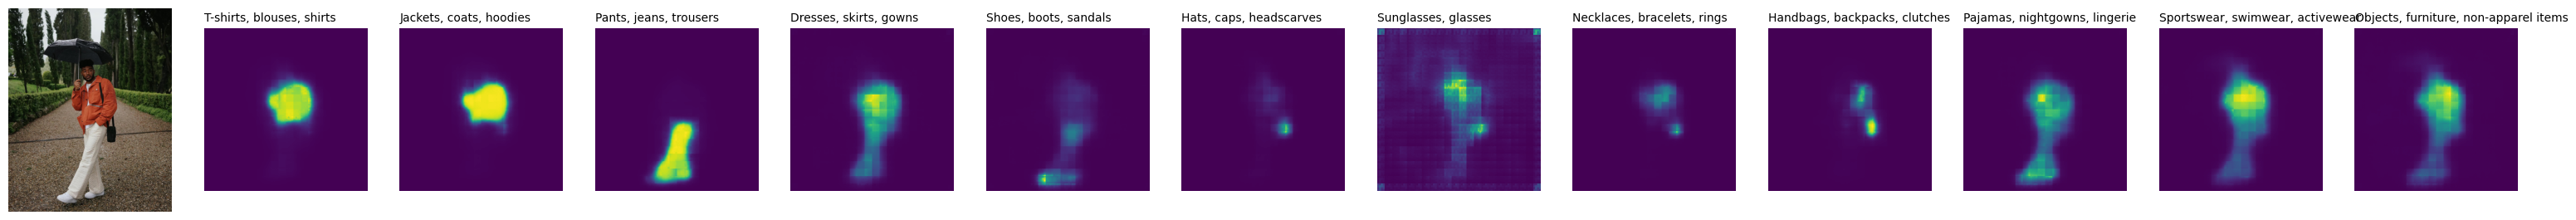

In [ ]:
url = "/content/sample_data/jtims1.jpeg"
image = Image.open(url)
prompts = clothing_categories
inputs = processor(text=prompts, images=[image] * len(prompts), padding=True, return_tensors="pt")

with torch.no_grad():
  outputs = model(**inputs)
preds = outputs.logits.unsqueeze(1)

_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];

In [ ]:
preds

In [ ]:
# Process into single segmented image

threshold = 0.1
flat_preds = torch.sigmoid(preds.squeeze()).reshape((preds.shape[0], -1))
flat_preds_with_threshold = torch.full((preds.shape[0] + 1, flat_preds.shape[-1]), threshold)
flat_preds_with_threshold[1:preds.shape[0]+1,:] = flat_preds
inds = torch.topk(flat_preds_with_threshold, 1, dim=0).indices.reshape((preds.shape[-2], preds.shape[-1]))

In [ ]:
inds

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

## Refined test

In [ ]:
inputs = processor(text=clothing_categories, images=[image] * len(clothing_categories),
                padding="max_length", return_tensors="pt")

with torch.no_grad():
  outputs = model(**inputs)

# Resize the outputs to match original image size
preds = nn.functional.interpolate(
    outputs.logits.unsqueeze(1),
    size=(image.size[1], image.size[0]),
    mode="bilinear"
)


original_image_size = (image.height, image.width)

threshold = 0.5
flat_preds = torch.sigmoid(preds.squeeze()).reshape((preds.shape[0], -1))
flat_preds_with_threshold = torch.full((preds.shape[0] + 1, flat_preds.shape[-1]), threshold)
flat_preds_with_threshold[1:preds.shape[0]+1,:] = flat_preds
inds = torch.topk(flat_preds_with_threshold, 1, dim=0).indices.reshape((preds.shape[-2], preds.shape[-1]))

# Convert the PyTorch tensor to a numpy array
segmentation_map_np = inds.cpu().numpy()

# Define your label_map based on your categories
label_map = {i: label for i, label in enumerate(clothing_categories)}

# Now you can use your helper functions with the segmentation_map_np and label_map
label_coordinates_map = map_coordinates_to_labels(segmentation_map_np, label_map)
masks = segmentation_to_masks(segmentation_map_np, label_map)
bounding_boxes = segmentation_to_bounding_boxes(segmentation_map_np, label_map)

# high confidence predictions only
overlay_bounding_boxes_on_image(image, bounding_boxes)

In [ ]:
# high confidence predictions only
bounding_boxes

{0: {'minX': 0, 'minY': 0, 'maxX': 1439, 'maxY': 1799},
 2: {'minX': 547, 'minY': 594, 'maxX': 947, 'maxY': 1024},
 9: {'minX': 857, 'minY': 1003, 'maxX': 952, 'maxY': 1197},
 5: {'minX': 441, 'minY': 1540, 'maxX': 783, 'maxY': 1722}}

In [ ]:
# high confidence predictions only
overlay_bounding_boxes_on_image(image, bounding_boxes)

In [ ]:
# Updated part for displaying masks with confidence
for i in range(len(prompts)):
    sigmoid_preds = torch.sigmoid(preds[i][0])
    ax[i+1].imshow(sigmoid_preds)
    confidence = sigmoid_preds.max().item()  # Get the maximum confidence score for the mask
    text = f"{prompts[i]}\nConfidence: {confidence:.2f}"  # Combine the prompt with confidence
    ax[i+1].text(0, -15, text, fontsize=8, color='white')  # Display the text

plt.show()

## High threshold test

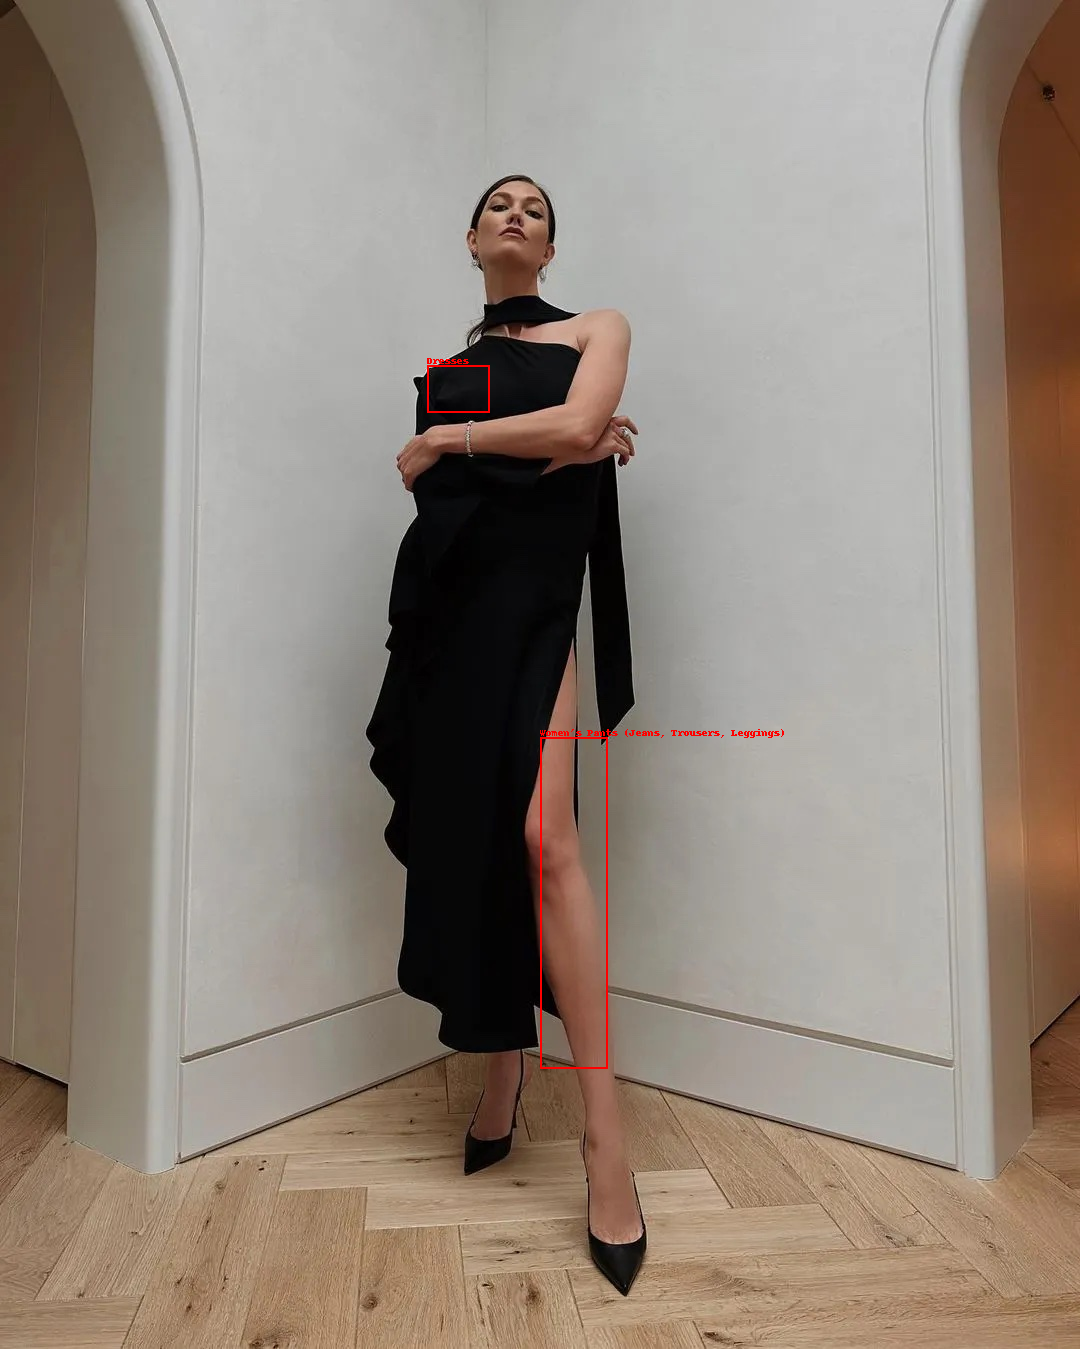

In [ ]:
url = "/content/sample_data/kkloss2.jpeg"
image = Image.open(url)

inputs = processor(text=clothing_categories, images=[image] * len(clothing_categories),
                padding="max_length", return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

# Resize the outputs to match original image size
preds = nn.functional.interpolate(
    outputs.logits.unsqueeze(1),
    size=(image.size[1], image.size[0]),
    mode="bilinear"
)

original_image_size = (image.height, image.width)

# Improved Thresholding Logic
threshold = 0.75  # Set a higher threshold for more confidence
sigmoid_preds = torch.sigmoid(preds.squeeze())

# Apply the threshold to filter out low probability predictions
high_confidence_masks = (sigmoid_preds > threshold).type(torch.uint8)

# Create a numpy array for each category mask
segmentation_maps_np = [mask.cpu().numpy() for mask in high_confidence_masks]

# Initialize collections for high confidence masks, bounding boxes
high_confidence_masks = {}
bounding_boxes = {}

# Process each category separately
for i, category in enumerate(clothing_categories):
    mask = segmentation_maps_np[i]
    if mask.sum() > 0:  # Check if there are high confidence areas
        high_confidence_masks[category] = mask
        bounding_boxes[category] = calculate_bounding_box(mask)

# Overlay bounding boxes for high confidence categories
overlayed_image = overlay_bounding_boxes_on_image(image, bounding_boxes)

overlayed_image